In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go

plt.rcParams['figure.figsize'] = 15, 5

**Using AMD stock values as the underlying aset**

<Axes: xlabel='Date'>

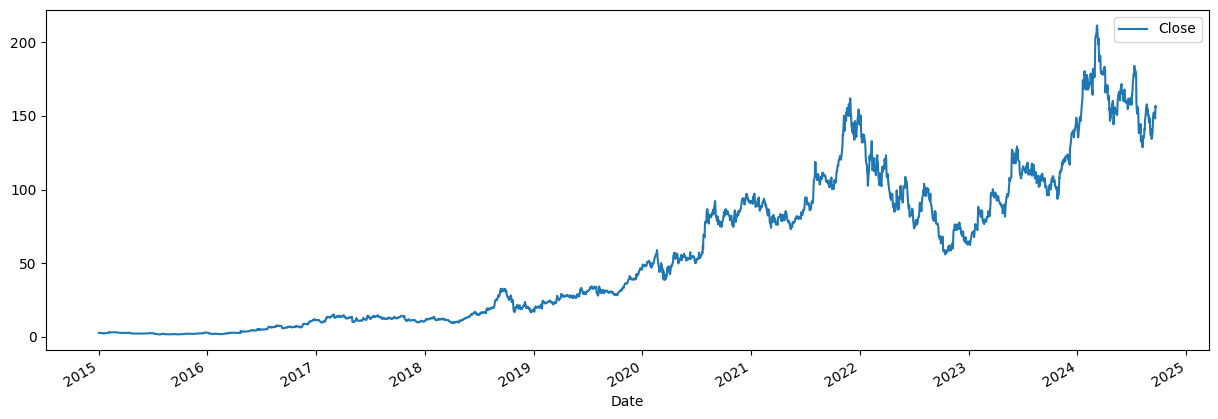

In [ ]:
AMD = yf.Ticker('AMD')
AMD_values = AMD.history(start = '2015-01-01')
AMD_values[['Close']].plot()

In [ ]:
# Return rate
AMD_values['Returns'] = np.log(AMD_values['Close'] / AMD_values['Close'].shift(1))

In [ ]:
# Compute daily volatility
daily_volatility = np.std(AMD_values['Returns'])

# Compute sigma
sigma = daily_volatility * np.sqrt(252)

**Binomial Tree model**

In [ ]:
# Option Pricing Model (Binomial Tree)
def binomial_tree(K, S0, r, T, N, sigma, opttype_1 = 'European', opttype_2 = 'C'):
    h = T / N
    u = np.exp(r * h + sigma * np.sqrt(h))
    d = np.exp(r * h - sigma * np.sqrt(h))
    p = (np.exp(r * h) - d) / (u - d)
    disc = np.exp(- r * h)

    # Initialize Asset Values:
    S = S0 * d ** np.arange(N, -1, -1) * u ** np.arange(0, N+1, 1)
    St = [S.copy()]  # Store the stock value at maturity

    # Compute option values at the final node
    price = np.maximum(S - K, np.zeros(N+1)) if opttype_2 == 'C' else np.maximum(K - S, np.zeros(N+1))


    # Store the initial payoffs (at maturity)
    option_values = [price.copy()]

    # Create a list to store delta and B
    delta_values = []
    B_values = []

    # Calculate Option Price at each nodes:
    for i in np.arange(N, 0, -1):
        # Compute delta values
        delta = (price[1:i+1] - price[0:i]) / (S[1:i+1] - S[0:i])
        delta_values.append(delta.copy())

        # Compute B values
        B = disc * (u * price[0:i] - d * price[1:i+1]) / (u - d)
        B_values.append(B.copy())

        # Compute stock values at each nodes
        S = disc * (p * S[1:i+1] + (1-p) * S[0:i])
        St.append(S.copy())  # Store value of stock at each step.

        # Compute option values at each nodes
        if opttype_1 == 'European':
          price = disc * (p * price[1:i+1] + (1-p) * price[0:i])
        elif opttype_1 == 'American':
          price = np.maximum(S - K, disc * (p * price[1:i+1] + (1-p) * price[0:i])) if opttype_2 == 'C' else np.maximum(K - S, disc * (p * price[1:i+1] + (1-p) * price[0:i]))
        option_values.append(price.copy())

    # Reverse to have values from the initial node down to maturity
    option_values.reverse()
    delta_values.reverse()
    B_values.reverse()
    St.reverse()

    return option_values, delta_values, B_values, St

**Graph the tree**

In [ ]:
def draw_binomial_tree_plotly(call_option_values, delta_values, B_values, St, periods):
    fig = go.Figure()

    # Draw nodes and connect them
    for i in range(periods + 1):
        x = i  # Set x position (horizontal)
        for j in range(i + 1):
            y = j - 0.5 * i  # Set y position (nodes spaced out)
            stock_value = St[i][j]
            delta_value = delta_values[i][j] if i < len(delta_values) else None
            B_value = B_values[i][j] if i < len(B_values) else None

            # Add Call Option value to node
            call_value = call_option_values[i][j]

            # Create node label with Option value, Delta, B values, and Call Option price
            node_text = (f'S: {stock_value:.2f}<br>'
                         f'Δ: {delta_value:.2f}<br>'
                         f'B: {B_value:.2f}<br>'
                         f'Price: {call_value:.2f}' if delta_value is not None and B_value is not None else f'S: {stock_value:.2f}<br>Price: {call_value:.2f}')

            fig.add_trace(go.Scatter(x=[x], y=[y], text=node_text, mode='markers+text',
                                     textposition='top center', marker=dict(size=14),
                                     textfont=dict(size=12, family="Arial")))

            # Draw lines connecting the nodes
            if i < periods:
                fig.add_trace(go.Scatter(x=[x, x + 1], y=[y, y - 0.5], mode='lines', line=dict(color='black', width=2)))
                fig.add_trace(go.Scatter(x=[x, x + 1], y=[y, y + 0.5], mode='lines', line=dict(color='black', width=2)))

    # Customize the layout of the plot (horizontal)
    fig.update_layout(showlegend=False,
                      title='Binomial Tree for Pricing Option',
                      title_x=0.5,  # Center the title
                      font=dict(size=14),  # Increase font size
                      xaxis=dict(visible=False),
                      yaxis=dict(visible=False),
                      plot_bgcolor='white',
                      width=1000, height=800)  # Increase plot size

    fig.show()


In [ ]:
K = 150  # Strike price
S0 = AMD_values['Close'].iloc[-1]  # Initial stock price
r = 3.73 / 100  # Risk-free rate
T = 1  # Time to maturity
N = 5  # Number of time steps
sigma
opttype_1 = 'European'
opttype_2 = 'C'

# Gọi hàm để tính giá trị quyền chọn và giá trị delta, B values
option_values, delta_values, B_values, St = binomial_tree(K, S0, r, T, N, sigma, opttype_1, opttype_2)

# Vẽ cây nhị phân với Plotly (nằm ngang và có đầy đủ Delta, B values, Option values và giá Call Option)
draw_binomial_tree_plotly(option_values, delta_values, B_values, St, N)

**Black - Scholes model**

In [ ]:
# Black Scholes Option Pricing function
def BlackScholes(K, S0, r, sigma, T, div, opttype_1 = 'European', opttype_2 = 'C'):
  d1 = (np.log(S0 / K) + (r + sigma**2 / 2)*T) / (sigma * np.sqrt(T))
  d2 = d1 - (sigma * np.sqrt(T))

  # Option Pricing
  if opttype_1 == 'European':
   price = (S0 * norm.cdf(d1, 0, 1) - K * np.exp(-r*T) * norm.cdf(d2, 0, 1)) if opttype_2 == 'C' else (K * np.exp(-r*T) * norm.cdf(-d2, 0, 1) - S0 * norm.cdf(-d1, 0 ,1))
  else:
    price = max(S - K, (S0 * norm.cdf(d1, 0, 1) - K * np.exp(-r*T) * norm.cdf(d2, 0, 1))) if opttype_2 == 'C' else max(K - S, (K * np.exp(-r*T) * norm.cdf(-d2, 0, 1) - S0 * norm.cdf(-d1, 0 ,1)))

  return price

In [ ]:
K = 150  # Strike price
S0 = AMD_values['Close'].iloc[-1]  # Initial stock price
r = 3.73 / 100  # Risk-free rate
T = 1  # Time to maturity
div = 0
sigma
opttype_1 = 'European'
opttype_2 = 'C'
BlackScholes(K, S0, r, sigma, T, div, opttype_1 , opttype_2)

40.354434479857595